In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Updated for scikit-learn 1.2+ (plot_roc_curve is deprecated)
from sklearn.metrics import RocCurveDisplay



In [2]:
df = pd.read_csv('heart-disease.csv')  # Note: filename has hyphen, not underscore
df.shape

(303, 14)

In [3]:
df["target"].value_counts()
df["target"].value_counts().plot(kind='bar', color=['salmon', 'lightblue']);


In [7]:
df["sex"].value_counts()

sex
1    207
0     96
Name: count, dtype: int64

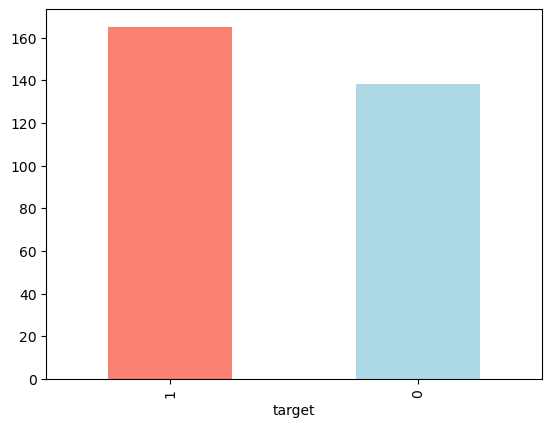

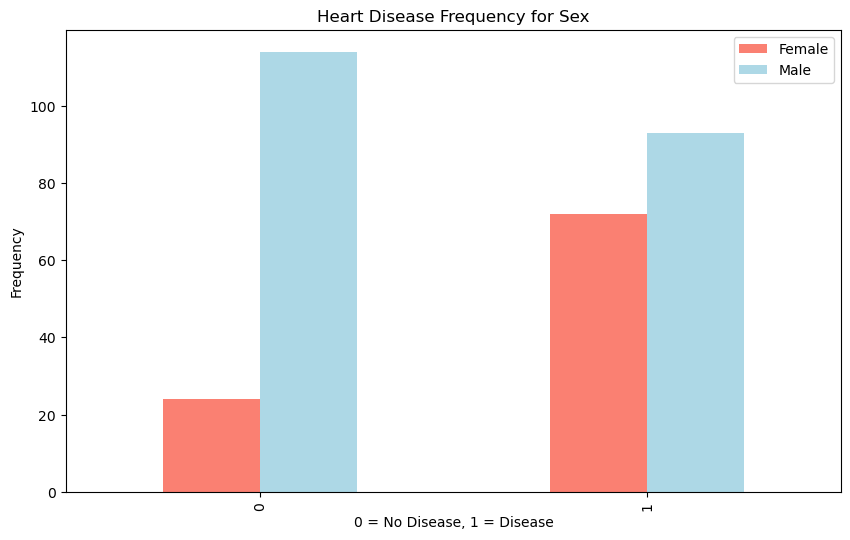

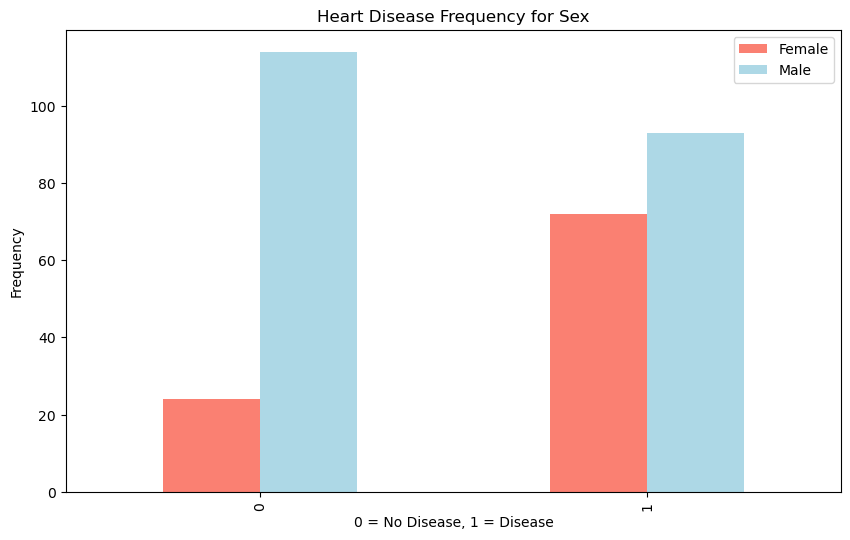

In [10]:
pd.crosstab(df.target, df.sex)
pd.crosstab(df.target, df.sex).plot(kind='bar',
                                    figsize=(10, 6),
                                    color=['salmon', 'lightblue'])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('0 = No Disease, 1 = Disease')
plt.ylabel('Frequency')
plt.legend(['Female', 'Male']);
plt.show()

In [ ]:
# Correlation Heatmap - Shows relationships between all features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Heatmap\n(Helps identify multicollinearity and feature importance)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
